In [138]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pandas as pd
import random

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [139]:
path = "/Users/muhammadhussain/Desktop/Data/filter/finished.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [140]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.485207,0.479290,0.476190,0.464286,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:29:05,Bad insulation,806031
1,0.479290,0.473373,0.464286,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:30:05,Bad insulation,806031
2,0.473373,0.461538,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:31:05,Bad insulation,806031
3,0.461538,0.449704,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,0.357143,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:32:05,Bad insulation,806031
4,0.449704,0.431953,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,0.357143,0.363095,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:33:05,Bad insulation,806031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146440,0.692308,0.615385,0.607143,0.607143,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:35:12,None,806278
146441,0.615385,0.603550,0.607143,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:36:12,None,806278
146442,0.603550,0.603550,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:37:12,None,806278
146443,0.603550,0.603550,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,0.595238,0.589286,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:38:13,None,806278


In [141]:
evaldatatrain["main_fault"].unique()

array(['Bad insulation', 'Electrical malfunction', 'Refrigerant leakage',
       '1st stage compressor', 'High condensation', 'Door tightness',
       'Wrong setpoint', '2nd stage compressor', 'Unstable operation',
       'None'], dtype=object)

In [142]:
# Hardcoded mapping for each string to a specific numeric value
fault_mapping = {
    'None': 0,
    'Electrical malfunction': 1,
    'Refrigerant leakage': 2,
    '1st stage compressor': 3,
    'High condensation': 4,
    'Door tightness': 5,
    'Wrong setpoint': 6,
    '2nd stage compressor': 7,
    'Unstable operation': 8,
    "Bad insulation": 9
}

# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Map each string to its corresponding numeric value
evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault'].map(fault_mapping)

# Hvis der findes værdier, der ikke er i fault_mapping, kan du evt. håndtere dem:
# evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault_numeric'].fillna(-1)

evaldatatrain


,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.485207,0.479290,0.476190,0.464286,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:29:05,Bad insulation,806031,9
1,0.479290,0.473373,0.464286,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:30:05,Bad insulation,806031,9
2,0.473373,0.461538,0.452381,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:31:05,Bad insulation,806031,9
3,0.461538,0.449704,0.434524,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,0.357143,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:32:05,Bad insulation,806031,9
4,0.449704,0.431953,0.404762,0.398810,0.380952,0.369048,0.363095,0.357143,0.357143,0.363095,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2023-02-27 12:33:05,Bad insulation,806031,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146440,0.692308,0.615385,0.607143,0.607143,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:35:12,None,806278,0
146441,0.615385,0.603550,0.607143,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:36:12,None,806278,0
146442,0.603550,0.603550,0.607143,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,0.595238,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:37:12,None,806278,0
146443,0.603550,0.603550,0.601190,0.601190,0.601190,0.595238,0.595238,0.595238,0.595238,0.589286,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-03-02 02:38:13,None,806278,0


In [143]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

Mapping of strings to numbers:
0: None
1: Electrical malfunction
2: Refrigerant leakage
3: 1st stage compressor
4: High condensation
5: Door tightness
6: Wrong setpoint
7: 2nd stage compressor
8: Unstable operation
9: Bad insulation


In [144]:
evaldatatrain["main_fault_numeric"].unique()

array([9, 1, 2, 3, 4, 5, 6, 7, 8, 0])

In [145]:
from sklearn.model_selection import train_test_split
import torch

# Definer input og output
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

# Split data i train, valid og test (40%, 40%, 20%)
x_temp, x_test, y_temp, y_test, time_temp, time_test, series_temp, series_test = train_test_split(
    inp, out, time, seriesnumber, test_size=0.2, stratify=out, random_state=42
)

x_train, x_valid, y_train, y_valid, time_train, time_valid, series_train, series_valid = train_test_split(
    x_temp, y_temp, time_temp, series_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Konverter til PyTorch tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
x_test = torch.tensor(x_test.values, dtype=torch.float32)

targets_train = torch.tensor(y_train.values, dtype=torch.int64)
targets_valid = torch.tensor(y_valid.values, dtype=torch.int64)
targets_test = torch.tensor(y_test.values, dtype=torch.int64)

# Lav også tids- og seriesnummerlister for senere analyse
time_train = time_train.reset_index(drop=True)
time_valid = time_valid.reset_index(drop=True)
time_test = time_test.reset_index(drop=True)

series_train = series_train.reset_index(drop=True)
series_valid = series_valid.reset_index(drop=True)
series_test = series_test.reset_index(drop=True)

# Bekræft fordelingen med pandas value_counts()
print("Train target distribution:", y_train.value_counts().to_dict())
print("Valid target distribution:", y_valid.value_counts().to_dict())
print("Test target distribution:", y_test.value_counts().to_dict())


Train target distribution: {3: 13656, 8: 6816, 1: 6815, 5: 6772, 2: 5645, 0: 5325, 7: 4384, 4: 3421, 6: 3385, 9: 2359}
Valid target distribution: {3: 13656, 8: 6816, 1: 6815, 5: 6771, 2: 5646, 0: 5325, 7: 4385, 4: 3421, 6: 3385, 9: 2358}
Test target distribution: {3: 6828, 8: 3408, 1: 3408, 5: 3386, 2: 2823, 0: 2663, 7: 2192, 4: 1710, 6: 1692, 9: 1179}


In [146]:
# To speed up training we'll only work on a subset of the data
#x_train = inp[:round(len(inp)/3)]
#targets_train = out[:round(len(inp)/3)]

#x_valid = inp[round(len(inp)/3):round(2*len(inp)/3)]
#targets_valid = out[round(len(inp)/3):round(2*len(inp)/3)]

#x_test = inp[round(2*len(inp)/3):]
#targets_test = out[round(2*len(inp)/3):]

#from sklearn.model_selection import train_test_split
#import torch

#x_train = inp[:1000]
#targets_train = out[:1000]

#x_valid = inp[1000:2000]
#targets_valid = out[1000:2000]

#x_test = inp[2000:3000]
#targets_test = out[2000:3000]


print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([58578, 360])
targets_train torch.Size([58578])
x_valid torch.Size([58578, 360])
targets_valid torch.Size([58578])
x_test torch.Size([29289, 360])
targets_test torch.Size([29289])


In [147]:
x_train.shape[1]

360

In [148]:
# Hyperparameters
num_classes = 10
num_l1 = 32  # Size of the first hidden layer
num_l2 = 16  # Size of the second hidden layer
num_l3 = 8   # Size of the third hidden layer
num_features = x_train.shape[1]
sequence_length = 30  # Number of features per sequence
num_sequences = num_features // sequence_length  # Number of sequences

# Ensure input features are divisible by sequence length
assert num_features % sequence_length == 0, "Total number of features must be divisible by the sequence length."

# Define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_hidden3, num_output):
        super(Net, self).__init__()

        # Create one LSTM for each feature
        self.rnn_layers = nn.ModuleList([
            nn.LSTM(input_size=sequence_length, hidden_size=16, batch_first=True)
            for _ in range(num_sequences)
        ])

        # Input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden1, num_sequences * 16)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # BatchNorm for input layer
        self.norm1 = nn.BatchNorm1d(num_features=num_hidden1)

        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        # BatchNorm for hidden layer 1
        self.norm2 = nn.BatchNorm1d(num_features=num_hidden2)

        # Hidden layer 2
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden3, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden3), 0))
        # BatchNorm for hidden layer 2
        self.norm3 = nn.BatchNorm1d(num_features=num_hidden3)

        # Output layer
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(num_output, num_hidden3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        # Reshape input into (batch_size, num_sequences, sequence_length)
        batch_size = x.size(0)
        x = x.view(batch_size, num_sequences, sequence_length)

        # Process each sequence with its respective RNN
        rnn_outputs = []
        for i, rnn in enumerate(self.rnn_layers):
            sequence_input = x[:, i, :].unsqueeze(1)  # Extract sequence for this feature
            rnn_out, _ = rnn(sequence_input)  # rnn_out shape: (batch_size, 1, hidden_size)
            rnn_outputs.append(rnn_out[:, -1, :])  # Take the last hidden state

        # Concatenate outputs from all RNNs
        x = torch.cat(rnn_outputs, dim=1)  # Shape: (batch_size, num_sequences * hidden_size)

        # Input layer
        x = self.dropout(x)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.norm1(x)
        x = self.activation(x)

        # Hidden layer 1
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.norm2(x)
        x = self.activation(x)

        # Hidden layer 2
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.norm3(x)
        x = self.activation(x)

        # Output layer
        x = F.linear(x, self.W_4, self.b_4)

        return x

# Initialize the network
net = Net(num_features, num_l1, num_l2, num_l3, num_classes)


In [149]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 3.131498 , Train acc 0.928085, Valid acc 0.928496
Epoch 11 : Train Loss 1.565835 , Train acc 0.932325, Valid acc 0.934068
Epoch 21 : Train Loss 1.551066 , Train acc 0.914906, Valid acc 0.913932
Epoch 31 : Train Loss 1.555980 , Train acc 0.969419, Valid acc 0.969521
Epoch 41 : Train Loss 1.552591 , Train acc 0.943316, Valid acc 0.943453
Epoch 51 : Train Loss 1.551495 , Train acc 0.948291, Valid acc 0.949333
Epoch 61 : Train Loss 1.539465 , Train acc 0.918000, Valid acc 0.920137
Epoch 71 : Train Loss 1.533576 , Train acc 0.952701, Valid acc 0.953077
Epoch 81 : Train Loss 1.545066 , Train acc 0.927009, Valid acc 0.929556
Epoch 91 : Train Loss 1.540919 , Train acc 0.963641, Valid acc 0.964274
Model saved to trained_modelFFNN.pth


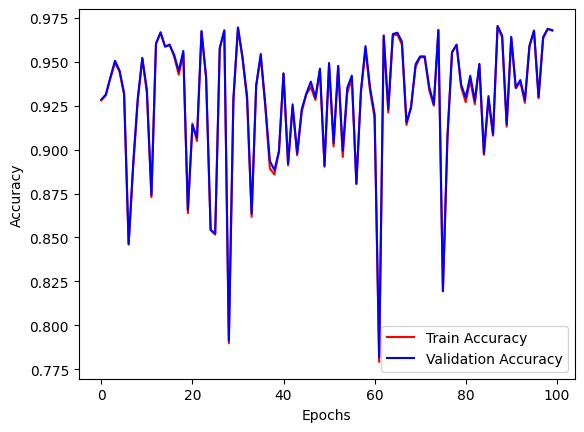

In [150]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt

# setting hyperparameters and getting epoch sizes
batch_size = 150
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprop -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

# Save the model's parameters
model_path = "trained_modelFFNN.pth"
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot accuracy
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.show()


In [151]:
print(y_train.value_counts(normalize=False))
print(y_valid.value_counts(normalize=True))

main_fault_numeric
3    13656
8     6816
1     6815
5     6772
2     5645
0     5325
7     4384
4     3421
6     3385
9     2359
Name: count, dtype: int64
main_fault_numeric
3    0.233125
8    0.116358
1    0.116341
5    0.115589
2    0.096384
0    0.090904
7    0.074857
4    0.058401
6    0.057786
9    0.040254
Name: proportion, dtype: float64


In [152]:
# Indlæs modellen
num_classes = 10 
num_l1 = 32  # Increased size of the first hidden layer
num_l2 = 16  # Added a second hidden layer
num_l3 = 8   # Added a third hidden layer
num_features = x_train.shape[1]


net_loaded = Net(num_features, num_l1,num_l2,num_l3  ,num_classes)  # Sørg for at bruge samme arkitektur
net_loaded.load_state_dict(torch.load(model_path))
net_loaded.eval()  # Sæt modellen i evalueringsmodus

print("Model loaded successfully!")


Model loaded successfully!


In [153]:
net.eval()

Net(
  (rnn_layers): ModuleList(
    (0-11): 12 x LSTM(30, 16, batch_first=True)
  )
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): ReLU()
)

In [154]:
output = net(x_test)
output

tensor([[ 0.0454, -3.1824,  0.9270,  ..., -1.7741,  4.6145,  0.8164],
        [ 0.0289,  0.6423, -1.1832,  ...,  0.6017,  1.4382, -2.4274],
        [ 2.7270,  0.9298, -0.8197,  ..., -2.1969, -2.4393, -1.9434],
        ...,
        [-2.7048,  0.3655, -0.8539,  ...,  5.1100, -1.5612,  2.2689],
        [-2.1443,  0.6470, -0.9406,  ...,  3.6369, -1.3199,  0.7607],
        [-0.9603,  3.8856,  1.1235,  ..., -0.0606, -2.1011, -1.8773]],
       grad_fn=<AddmmBackward0>)

In [155]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([8, 5, 6,  ..., 7, 7, 1])

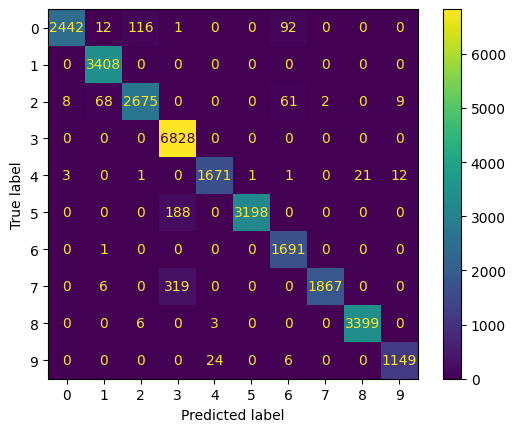

In [156]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targets_test, predictedclass)
precision = precision_score(targets_test, predictedclass, average='weighted')
recall = recall_score(targets_test, predictedclass, average='weighted')
f1 = f1_score(targets_test, predictedclass, average='weighted')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", precision)
print("f1:", precision)

In [157]:
targets_test.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [158]:
predictedclass.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [159]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

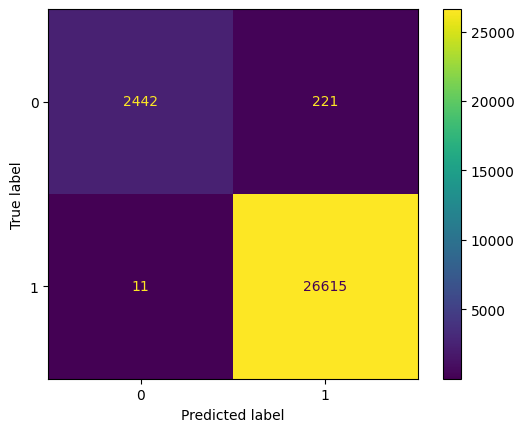

In [160]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()

In [161]:
unique_values, counts = torch.unique(targets_train, return_counts=True)

print("Unikke værdier:", unique_values)
print("Hyppigheder:", counts)

Unikke værdier: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Hyppigheder: tensor([ 5325,  6815,  5645, 13656,  3421,  6772,  3385,  4384,  6816,  2359])


Test model for unseen data.

In [175]:
path = "/Users/muhammadhussain/Desktop/Data/filter/excluded.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [176]:
evaldatatrain = pd.read_parquet(path)
evaldatatrain = evaldatatrain.drop(columns=["main_fault_0", "Type_0", "Event_0"])
evaldatatrain

,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_23,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber
0,0.455090,0.463855,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:29:12,Refrigerant leakage,806017
1,0.461078,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:30:12,Refrigerant leakage,806017
2,0.467066,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:31:12,Refrigerant leakage,806017
3,0.467066,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:32:12,Refrigerant leakage,806017
4,0.467066,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,0.343373,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:33:12,Refrigerant leakage,806017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74268,0.401198,0.427711,0.439759,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:28:12,None,806278
74269,0.425150,0.439759,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:29:12,None,806278
74270,0.437126,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,0.421687,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:30:12,None,806278
74271,0.443114,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,0.421687,0.379518,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.000000,2013-02-24 23:31:12,None,806278


In [177]:
evaldatatrain["main_fault"].unique()

array(['Refrigerant leakage', 'High condensation', 'Unstable operation',
       '2nd stage compressor', 'Electrical malfunction', 'None'],
      dtype=object)

In [178]:
# Hardcoded mapping for each string to a specific numeric value
fault_mapping = {
    'None': 0,
    'Electrical malfunction': 1,
    'Refrigerant leakage': 2,
    '1st stage compressor': 3,
    'High condensation': 4,
    'Door tightness': 5,
    'Wrong setpoint': 6,
    '2nd stage compressor': 7,
    'Unstable operation': 8,
}

# Replace NaN with "None"
evaldatatrain['main_fault'] = evaldatatrain['main_fault'].fillna('None')

# Map each string to its corresponding numeric value
evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault'].map(fault_mapping)

# Hvis der findes værdier, der ikke er i fault_mapping, kan du evt. håndtere dem:
# evaldatatrain['main_fault_numeric'] = evaldatatrain['main_fault_numeric'].fillna(-1)

evaldatatrain


,RTD_0,RTD_1,RTD_2,RTD_3,RTD_4,RTD_5,RTD_6,RTD_7,RTD_8,RTD_9,...,State_24,State_25,State_26,State_27,State_28,State_29,Datetime,main_fault,seriesnumber,main_fault_numeric
0,0.455090,0.463855,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:29:12,Refrigerant leakage,806017,2
1,0.461078,0.469880,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:30:12,Refrigerant leakage,806017,2
2,0.467066,0.469880,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:31:12,Refrigerant leakage,806017,2
3,0.467066,0.469880,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:32:12,Refrigerant leakage,806017,2
4,0.467066,0.469880,0.475904,0.475904,0.469880,0.457831,0.433735,0.385542,0.355422,0.343373,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2015-03-16 12:33:12,Refrigerant leakage,806017,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74268,0.401198,0.427711,0.439759,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:28:12,None,806278,0
74269,0.425150,0.439759,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:29:12,None,806278,0
74270,0.437126,0.445783,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,0.421687,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,2013-02-24 23:30:12,None,806278,0
74271,0.443114,0.463855,0.463855,0.469880,0.469880,0.469880,0.457831,0.445783,0.421687,0.379518,...,0.157895,0.157895,0.157895,0.157895,0.157895,0.000000,2013-02-24 23:31:12,None,806278,0


In [179]:
evaldatatrain["main_fault_numeric"].unique()

array([2, 4, 8, 7, 1, 0])

In [180]:
# Get unique pairs of main_fault and main_fault_numeric
unique_pairs = evaldatatrain[['main_fault', 'main_fault_numeric']].drop_duplicates().sort_values(by='main_fault_numeric')

# Print the mapping
print("Mapping of strings to numbers:")
for index, row in unique_pairs.iterrows():
    print(f"{row['main_fault_numeric']}: {row['main_fault']}")

Mapping of strings to numbers:
0: None
1: Electrical malfunction
2: Refrigerant leakage
4: High condensation
7: 2nd stage compressor
8: Unstable operation


In [181]:
inp = evaldatatrain.drop(columns=["Datetime", "main_fault", "seriesnumber", "main_fault_numeric"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["main_fault_numeric"]
seriesnumber = evaldatatrain["seriesnumber"]

In [182]:
x_test = torch.tensor(inp.values, dtype=torch.float32)
targets_test = torch.tensor(out.values, dtype=torch.int64)

In [183]:
output = net(x_test)
output

tensor([[-0.5576,  0.1191, -0.8070,  ...,  1.0600, -1.0833, -2.2928],
        [-0.6705,  0.0751, -0.6844,  ...,  1.1484, -1.0287, -2.2578],
        [-0.6779,  0.0136, -0.6548,  ...,  1.1523, -0.9754, -2.2713],
        ...,
        [-1.5929,  0.4922, -0.7533,  ...,  2.2464, -1.7797, -1.1515],
        [-1.4593,  0.4180, -0.8734,  ...,  2.1438, -1.7717, -1.2169],
        [-1.2306,  0.1274, -0.9474,  ...,  1.9371, -1.6094, -1.4507]],
       grad_fn=<AddmmBackward0>)

In [184]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([3, 3, 3,  ..., 3, 3, 3])

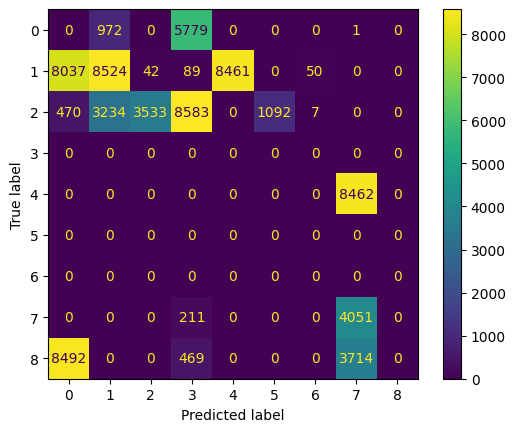

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(targets_test, predictedclass)
precision = precision_score(targets_test, predictedclass, average='weighted')
recall = recall_score(targets_test, predictedclass, average='weighted')
f1 = f1_score(targets_test, predictedclass, average='weighted')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", precision)
print("f1:", precision)

Accuracy: 0.2168755806282229
Precision: 0.46665771539128925
Recall: 0.46665771539128925
f1: 0.46665771539128925


/opt/anaconda3/envs/[neuralnetwork]/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/[neuralnetwork]/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [186]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

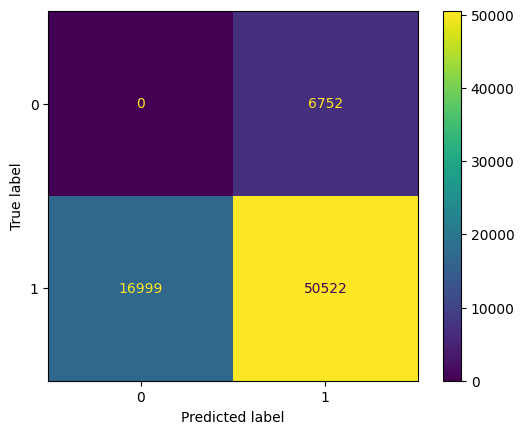

In [187]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()